# Setup

**Imports**

In [1]:
import datetime as dt
from math import log
import IPython

import collections
import matplotlib.pyplot as plt
import numpy as np
!pip install ruptures
import ruptures as rpt
from ruptures.base import BaseCost
from ruptures.metrics import hausdorff
from scipy.signal import chirp, stft, sweep_poly, find_peaks
from scipy.fft import fft

rng = np.random.default_rng()


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


**Utility functions**

In [2]:
tones = {"1": (697, 1209), "2": (697, 1336), "3": (697, 1477), "4": (770, 1209), "5": (770, 1336), "6": (770, 1477), "7": (852, 1209), "8": (852, 1336), "9": (852, 1477), "0": (941, 1336), "*": (941, 1209), "#": (941, 1477), "A": (697, 1633), "B": (770, 1633), "C": (852, 1633), "D": (941, 1633)}
FS = 22_050  # Hz
sigma = 2


def generate_symbol(symbol, duration, fs):
    """Generate the sound for number with given duration"""
    # get both frequencies for the symbol
    f1, f2 = tones[symbol]
    # time array
    time_arr = np.arange(0, duration, 1 / fs)
    # audio signal
    signal = np.cos(2 * np.pi * f1 * time_arr) + np.cos(2 * np.pi * f2 * time_arr)
    return signal

def generate_signal():
    n_symbols = rng.integers(3, 12)
    list_of_symbols = rng.choice(list("1234567890*#ABCD"), size=n_symbols)

    list_of_segments = list()

    for symbol in list_of_symbols:
        duration = rng.uniform(low=0.05, high=0.2)  # seconds
        # generate tone
        symbol_signal = generate_symbol(symbol=symbol, duration=duration, fs=FS)
        # generate silence
        silence = np.zeros(int(duration*FS))
        # append tone and silence
        list_of_segments.extend([symbol_signal, silence])

    # silence at the start
    silence = np.zeros(int(duration*FS))
    list_of_segments = [silence] + list_of_segments

    signal = np.concatenate(list_of_segments)
    n_samples = signal.shape[0]
    time_array = np.arange(n_samples) / FS
    
    # add nuissance
    inst_freq = np.sin(2 * np.pi * 1.2 * time_array) * 1500 + 2000
    poly = np.polyfit(x=time_array, y=inst_freq, deg=14)
    sin_freq = sweep_poly(time_array, poly)
    signal += sin_freq
    # add white noise
    signal += rng.normal(scale=sigma, size=n_samples)

    return signal, list_of_symbols.tolist()


# Question 1


[Dual-tone multi-frequency signaling](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling) is a procedure to encode symbols using audio signal.

A symbold is represented by a sum of cosine waves: for $t=0,1,\dots,T-1$,

$$
y_t = \cos(2\pi f_1 t/f_s) + \cos(2\pi f_2 t/f_s)
$$
where each combination of $(f_1, f_2)$ represents a symbols (see table below).


|         | 1209 Hz  | 1336 Hz  | 1477 Hz  | 1633 Hz  |
|---------|----------|----------|----------|----------|
| **697 Hz**  | 1        | 2        | 3        | A        |
| **770 Hz**  | 4        | 5        | 6        | B        |
| **852 Hz**  | 7        | 8        | 9        | C        |
| **941 Hz**  | *        | 0        | #        | D        |

In [3]:
signal, symbols = generate_signal()
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

B # # 6


In [4]:
class MultivariateNormalCost(BaseCost):

    """Custom cost for piecewise Poisson signals."""

    # The 2 following attributes must be specified for compatibility.
    model = "Poisson"
    min_size = 2

    def fit(self, signal):
        """Set the internal parameter."""
        self.signal = signal
        return self

    def error(self, start, end):
        """Return the approximation cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        subsignal = self.signal[start:end]
        cov_mat = np.cov(subsignal.T)
        _, val = np.linalg.slogdet(cov_mat)
        return (end-start)*val

In [5]:
def find_elbow_point(curve):
    curve = np.array(curve)
    # Normalize the curve to [0, 1]
    #points = (curve - np.min(curve)) / (np.max(curve) - np.min(curve))
    
    points = curve
    secondDerivative = collections.defaultdict(lambda:0)
    for i in range(1, points.shape[0] - 1):
        secondDerivative[i] = points[i+1] + points[i-1] - 2*points[i]
    max_index = list(secondDerivative.values()).index(max(secondDerivative.values()))
    elbow_index = max_index + 1
    return elbow_index

In [6]:
class ChangePointDetection():

  def __init__(self, signal, pen):
    self.signal = signal
    self.cost = MultivariateNormalCost()
    self.curve = None
    self.pen = pen

  def fit(self, signal):
    self.signal = signal
  
  def change_cost(self, cost):
    self.cost = cost
  
  def predict(self, m=1, M=21):

    f, t, Zxx = stft(self.signal, FS, nperseg=256)
    signal_freq = np.abs(Zxx.T)

    ''' 
    #if we don't know the number of breakpoints, we can use a penalization criterion
    if n_bkps == -1:
      algo = rpt.Pelt(model="l2", custom_cost=self.cost).fit(signal=signal_freq)
      predicted_bkps = algo.predict(pen=10) '''

    ''' #to know the number of bkps, we can use the elbow criterion on the sum_of_costs

    if self.curve is None:
      curve = []
      for n_bkps in range(m, M):
        algo = rpt.Pelt(model="l2", custom_cost=self.cost)
        bkps = algo.fit_predict(signal=signal_freq, n_bkps=n_bkps)
        #print(algo.cost.sum_of_costs(bkps))
        curve.append(algo.cost.sum_of_costs(bkps))
      self.curve = curve

    curve = self.curve
    #finding the elbow of the curve
    elbow_index = find_elbow_point(curve)
    n_bkps = elbow_index + 1

    #predicting the bkps
    algo = rpt.Dynp(model="l2", custom_cost=self.cost)
    predicted_bkps = algo.fit_predict(signal=signal_freq, n_bkps=n_bkps)

    return predicted_bkps '''


    #we can use Pelt

    algo = rpt.Pelt(jump=5, min_size = 1, model="l2").fit(signal=signal_freq)
    preds = algo.predict(pen=self.pen)

    return preds
  
  def decode(self):

    preds = self.predict()
    symbols = []
    start = 0

    f, t, Zxx = stft(self.signal, FS, nperseg=256)
    for end in preds:

      #get the frequencies with Zxx computed above
      segment_freq = np.abs(Zxx.T[start:end+1])

      #get the mean of the frequencies
      mean_freq = np.mean(segment_freq, axis=0)
      #get the two indexes associated with the two highest frequencies
      indexes = np.argsort(mean_freq)[-2:]
      #get the two highest frequencies
      f1, f2 = f[indexes[0]], f[indexes[1]]

      #find the best symbol
      best_symbol = None
      best_score = None
      for symbol in tones:
        score = min(abs(tones[symbol][0] - f1) + abs(tones[symbol][1] - f2), abs(tones[symbol][1] - f1) + abs(tones[symbol][0] - f2))
        if best_score is None or score < best_score:
          best_score = score
          best_symbol = symbol
      
      if best_score < 100:
        symbols.append(best_symbol)

      start = end+1
    
    return symbols

# Question 2

In [7]:
sound_1 = np.loadtxt("signal_1.csv")
sound_2 = np.loadtxt("signal_2.csv")

In [8]:
algo1 = ChangePointDetection(sound_1, pen=3)

In [9]:
algo2 = ChangePointDetection(sound_2, pen=3)

In [10]:
preds_1 = algo1.predict()
algo1.decode()

['B', '9', '4', 'B', '3', '8', 'B', '#', '1']

In [11]:
preds_2 = algo2.predict()
algo2.decode()

['C', 'D', '1', '1', '2', '6', '3', '9']

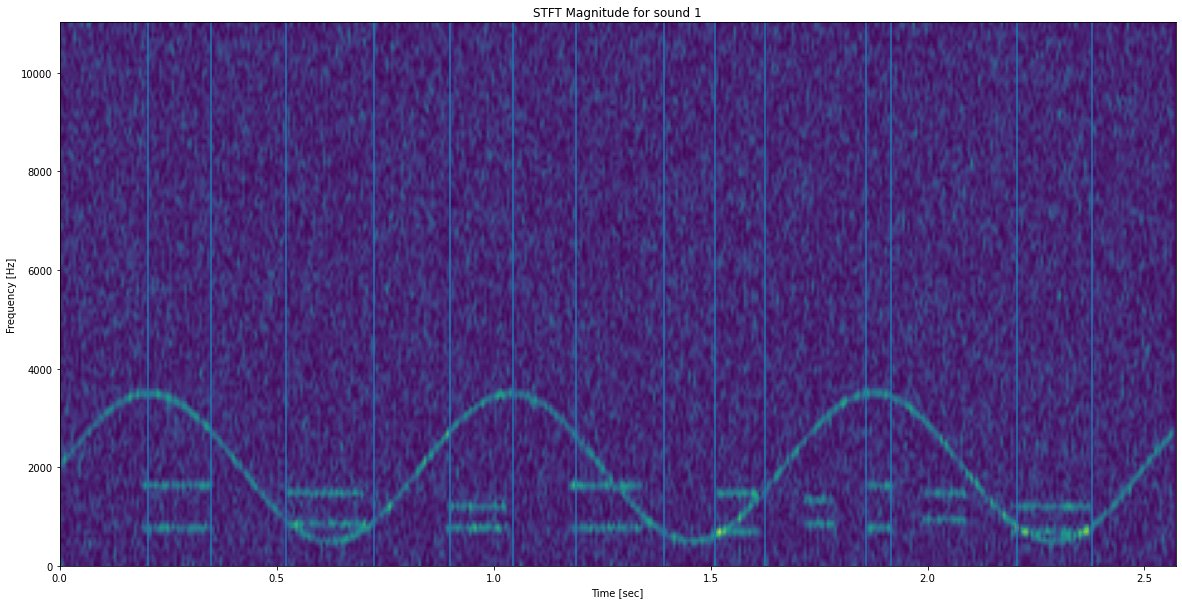

In [12]:
#checking with the stft
f, t, Zxx = stft(sound_1, FS, nperseg=256)

plt.figure(figsize=(20, 10))
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude for sound 1')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

for b in preds_1[:-1]:
    plt.axvline(t[b])

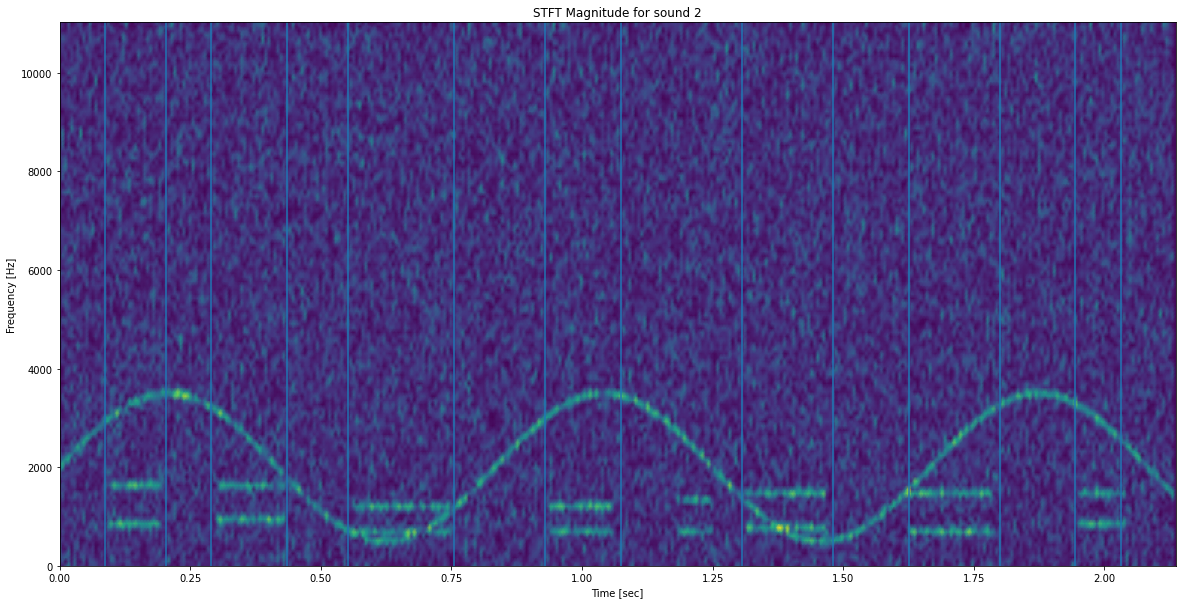

In [13]:
#same for sound 2
f, t, Zxx = stft(sound_2, FS, nperseg=256)

plt.figure(figsize=(20, 10))
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude for sound 2')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
for b in preds_2[:-1]:
    plt.axvline(t[b])

# Question 3

In [14]:
def g_hat_m(lambd, R, lambda_n, M, m):
    a = lambda_n/(M + 1 - R)
    
    def g_hat_U(x):
        return (1 + np.cos(2*np.pi*(x/(a*R) + 0.5)))/2*np.where(x < 0, 1, 0)*np.where(x > -R*a, 1, 0)
    
    return g_hat_U(lambd - a*m)

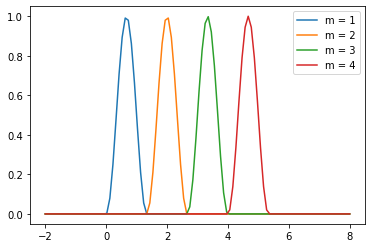

In [15]:
x = np.linspace(-2, 8, 100)

for m in range(1,5):
    y = g_hat_m(x, 1, 12, 9, m)
    plt.plot(x,y, label="m = %i"%m)

plt.legend()
plt.show()

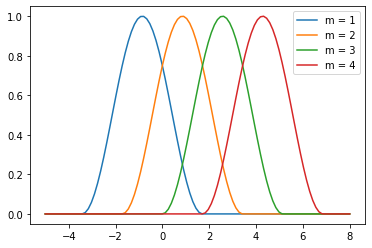

In [16]:
x = np.linspace(-5, 8, 100)

for m in range(1,5):
    y = g_hat_m(x, 3, 12, 9, m)
    plt.plot(x,y, label="m = %i"%m)

plt.legend()
plt.show()

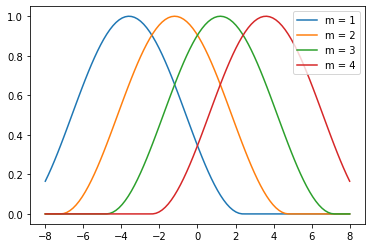

In [17]:
x = np.linspace(-8, 8, 100)

for m in range(1,5):
    y = g_hat_m(x, 5, 12, 9, m)
    plt.plot(x,y, label="m = %i"%m)

plt.legend()
plt.show()

# Question 4

In [ ]:
import pandas as pd
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from pygsp import graphs
import scipy as sp
from scipy.linalg import eigh
from scipy.spatial.distance import pdist, squareform
from scipy.fft import fft
from math import asin, cos, radians, sin, sqrt
from matplotlib.dates import DateFormatter

import geopandas
import contextily as cx

In [ ]:
data_df, stations_df, description = load_molene_meteo_dataset()

CRS = "EPSG:4326"

In [ ]:
#Data pre-processing
# convert temperature from Kelvin to Celsius
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius

#Pivoting the dataframe
temperature_df = data_df.pivot(
    index="date", values="temp", columns="station_name"
)

#Handling missing values
temperature_df.replace('NaN', np.nan)

temperature_df.head()

station_name,ARZAL,AURAY,BATZ,BEG_MEIL,BELLE ILE-LE TALUT,BIGNAN,BREST-GUIPAVAS,BRIGNOGAN,CAMARET,DINARD,...,SIBIRIL S A,SIZUN,SPEZET,ST BRIEUC,ST NAZAIRE-MONTOIR,ST-SEGAL S A,THEIX,TREGUNC,VANNES-MEUCON,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,9.7,10.3,NaN,NaN,11.3,7.1,9.7,NaN,NaN,6.8,...,7.4,8.5,8.3,7.5,9.0,9.0,9.3,10.8,8.5,9.7
2014-01-01 01:00:00,9.8,10.4,NaN,NaN,10.3,7.6,9.6,9.2,NaN,6.5,...,8.2,8.3,8.6,7.0,9.1,9.5,9.1,10.9,8.7,9.9
2014-01-01 02:00:00,9.7,10.0,NaN,NaN,11.2,7.7,9.1,9.4,NaN,6.5,...,8.5,8.5,8.6,7.5,9.5,9.4,9.4,10.6,8.8,9.6
2014-01-01 03:00:00,9.4,10.4,NaN,NaN,11.4,7.9,9.7,10.1,NaN,7.1,...,8.5,8.7,8.9,7.2,9.0,9.9,8.9,10.8,8.6,9.8
2014-01-01 04:00:00,9.8,10.8,NaN,NaN,11.4,8.8,9.8,10.2,NaN,7.6,...,9.1,9.1,9.4,7.6,9.5,10.0,9.6,11.0,9.2,10.2


In [ ]:
columns = temperature_df.loc[:, pd.isnull(temperature_df).any(axis=0)].columns
temperature_df = temperature_df.dropna(axis=1, how='any')

stations_df = stations_df.drop(stations_df[np.isin(stations_df["Nom"], columns.to_numpy())].index)

# convert pandas df to geopandas df
stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry=geopandas.points_from_xy(
        stations_df.Longitude, stations_df.Latitude
    ),
).set_crs(CRS)

In [ ]:
#Dropped columns
print(columns)

Index(['ARZAL', 'BATZ', 'BEG_MEIL', 'BREST-GUIPAVAS', 'BRIGNOGAN', 'CAMARET',
       'LANDIVISIAU', 'LANNAERO', 'LANVEOC', 'OUESSANT-STIFF', 'PLOUAY-SA',
       'PLOUDALMEZEAU', 'PLOUGONVELIN', 'QUIMPER', 'RIEC SUR BELON', 'SIZUN',
       'ST NAZAIRE-MONTOIR', 'VANNES-MEUCON'],
      dtype='object', name='station_name')


**Utility functions**

In [ ]:
def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

In [ ]:
def dms2dd(s):
    """Convert longitude and latitude strings to float."""
    # https://stackoverflow.com/a/50193328
    # example: s =  """48°51'18"""
    degrees, minutes, seconds = re.split("[°'\"]+", s[:-1])
    direction = s[-1]
    dd = float(degrees) + float(minutes) / 60 + float(seconds) / (60 * 60)
    if direction in ("S", "W"):
        dd *= -1
    return dd

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def get_exponential_similarity(
    condensed_distance_matrix, bandwidth, threshold
):
    exp_similarity = np.exp(
        -(condensed_distance_matrix ** 2) / bandwidth / bandwidth
    )
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

In [ ]:
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)

In [ ]:
sigma = np.median(dist_mat_condensed)  # median heuristic

connected = []
average_degree = []

for threshold in np.linspace(0,1,100):
    adjacency_matrix_gaussian = squareform(
        get_exponential_similarity(dist_mat_condensed, sigma, threshold)
    )
    G_gaussian = graphs.Graph(adjacency_matrix_gaussian)

    connected.append(40 if G_gaussian.is_connected(recompute=True) else 0)
    average_degree.append(G_gaussian.Ne*2/G_gaussian.N)

**Graph construction**

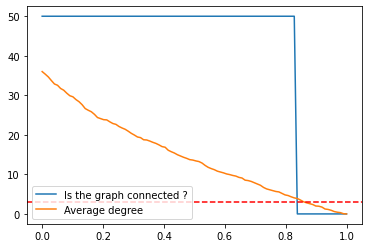

In [ ]:
plt.plot(np.linspace(0,1,100), connected, label="Is the graph connected ?")
plt.plot(np.linspace(0,1,100), average_degree, label="Average degree")
plt.axhline(y=3, color='r', linestyle='--')
plt.legend()
plt.show()

The threshold is approximately 0.83.

In [ ]:
threshold = 0.83

adjacency_matrix_gaussian = squareform(
    get_exponential_similarity(dist_mat_condensed, sigma, threshold)
)
G_gaussian = graphs.Graph(adjacency_matrix_gaussian)

**Smoothness**

In [ ]:
signals = temperature_df.to_numpy()
laplacian_matrix = G_gaussian.L.todense()

smoothness_arr = np.array(
    [float(signal.T.dot(laplacian_matrix).dot(signal)) for signal in signals]
)
smoothness_df = pd.Series(
    data=smoothness_arr, index=temperature_df.index
)

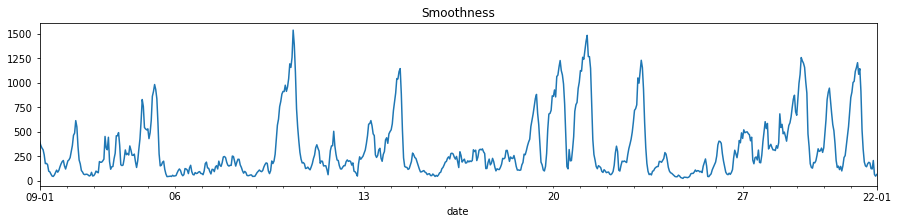

In [ ]:
fig, ax = fig_ax()
smoothness_df.plot(ax=ax)
myFmt = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(myFmt)
ax.set_title("Smoothness")
plt.grid(axis="x", color="0.95")

In [ ]:
#Smoothest
argmin_index = smoothness_df.argmin()
signal_argmin = temperature_df.iloc[argmin_index]
print(signal_argmin.name)

2014-01-24 19:00:00


In [ ]:
#Least smooth
argmax_index = smoothness_df.argmax()
signal_argmax = temperature_df.iloc[argmax_index]
print(signal_argmax.name)

2014-01-10 09:00:00


# Question 5

In [ ]:
R = 3

In [ ]:
def W(f, m, v, laplacian):
    eigenvals, eigenvecs = sp.linalg.eigh(laplacian)
    fft_signal = sp.fft.fft(f)
    
    return np.sum([g_hat_m(eigenvals[l], R, 12, 9, m)*fft_signal[l]*eigenvecs[l][v] for l in range(len(f))])

In [ ]:
def kind_frequency(features):
    low_energy = np.sum(features[0:3])
    medium_energy = np.sum(features[3:6])
    high_energy = np.sum(features[6:9])
    
    return np.argmax([low_energy, medium_energy, high_energy])

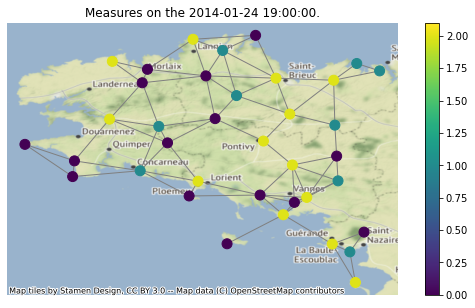

In [ ]:
#Smoothest
signal = signal_argmin.to_numpy()

features = np.array([[W(signal, k, v, laplacian_matrix) for k in range(1,9)] for v in range(G_gaussian.N)])

signal_frequency_class = np.array([kind_frequency(features_node) for features_node in features])

ax = stations_gdf.geometry.plot(figsize=(10, 5))

cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(signal_frequency_class, ax=ax)
_ = ax.set_title(
    f"Measures on the {temperature_df.index[argmin_index]}."
)

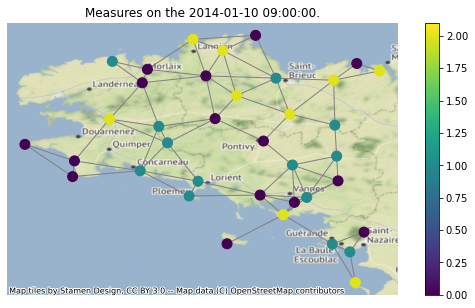

In [ ]:
#Least smooth
signal = signal_argmax.to_numpy()

features = np.array([[W(signal, k, v, laplacian_matrix) for k in range(1,9)] for v in range(G_gaussian.N)])

signal_frequency_class = np.array([kind_frequency(features_node) for features_node in features])

ax = stations_gdf.geometry.plot(figsize=(10, 5))

cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(signal_frequency_class, ax=ax)
_ = ax.set_title(
    f"Measures on the {temperature_df.index[argmax_index]}."
)

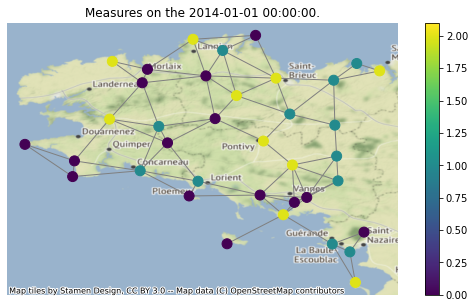

In [ ]:
#First available timestamp
signal = temperature_df.iloc[0].to_numpy()

features = np.array([[W(signal, k, v, laplacian_matrix) for k in range(1,9)] for v in range(G_gaussian.N)])

signal_frequency_class = np.array([kind_frequency(features_node) for features_node in features])

ax = stations_gdf.geometry.plot(figsize=(10, 5))

cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(signal_frequency_class, ax=ax)
_ = ax.set_title(
    f"Measures on the {temperature_df.index[0]}."
)

# Question 6

In [ ]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.margins(x=0)
    return fig, ax

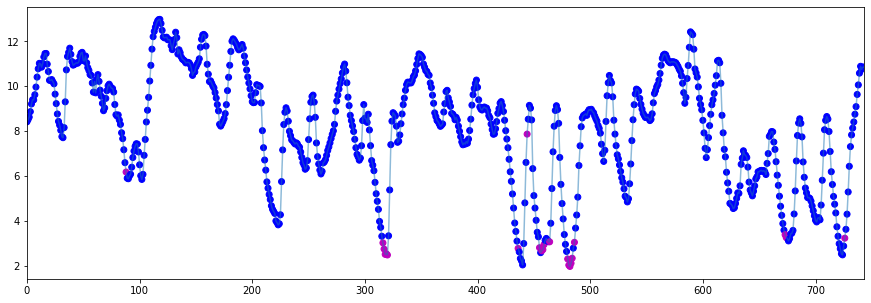

In [ ]:
y = np.mean(temperature_df.to_numpy(),axis=1)
x = np.arange(y.shape[0])
class_array = np.zeros(y.shape[0])

for i in range(y.shape[0]):
    signal = temperature_df.iloc[i].to_numpy()
    features = np.array([[W(signal, k, v, laplacian_matrix) for k in range(1,9)] for v in range(G_gaussian.N)])
    signal_frequency_class = np.array([kind_frequency(features_node) for features_node in features])
    
    values, counts = np.unique(signal_frequency_class, return_counts=True)
    class_array[i] = np.argmax(counts)

colors = ["b", "m", "r"]  # three colours=three classes
color_array = np.take(colors, class_array.astype(int))
fig, ax = fig_ax()
ax.plot(x, y, alpha=0.5)
ax.scatter(x, y, c=color_array)

# do not forget to explain the colours in the report

# Question 7

Notons $L_G \in \mathbb{R}^{n_1 \times n_1}$ et $L_{G'} \in \mathbb{R}^{n_2 \times n_2}$ les laplaciens de G et G'. Le sujet fait remarquer que $H = G \otimes G'$.

Alors $L_H = D_H - A_H$ où $D_H$ et $A_H$ sont la matrice de degrés et la matrice d'adjacence de H.

Les degrés de H valent alors $D_H = D_G \otimes I_{n_2} + I_{n_1} \otimes D_{G'}$ et la matrice d'adjacence $A_H = A_G \otimes I_{n_2} + I_{n_1} \otimes A_{G'} = (D_G - L_G) \otimes I_{n_2} + I_{n_1} \otimes (D_{G'} - L_{G'})$.

Donc $L_H = D_G \otimes I_{n_2} + I_{n_1} \otimes D_{G'} - (D_G - L_G) \otimes I_{n_2} + I_{n_1} \otimes (D_{G'} - L_{G'})$
$= L_G \otimes I_{n_2} + I_{n_1} \otimes L_{G'}$.




# Question 4

# Question 5

# Question 6

In [ ]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.margins(x=0)
    return fig, ax

In [ ]:
y = np.random.normal(size=600)  # dummy signal
x = np.arange(y.shape[0])
class_array = np.random.binomial(n=2, p=0.5, size=y.shape[0])  # dummy classes (0, 1, 2)


colors = ["b", "m", "r"]  # three colours=three classes
color_array = np.take(colors, class_array)
fig, ax = fig_ax()
ax.plot(x, y, alpha=0.5)
ax.scatter(x, y, c=color_array)

# do not forget to explain the colours in the report

# Question 7